In [27]:
# !pip install -U scikit-learn
# !python -m pip install -U pip
# !python -m pip install -U matplotlib
# !pip install --user scanpy

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.1 MB 6.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/2.1 MB 7.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/2.1 MB 5.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.0/2.1 MB 5.6 MB/s eta 0:00:01
   ----------------------- ------------

In [29]:
#import libraries
import sklearn.datasets
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc, anndata as ad

In [3]:
#finding the euclidean distance 
def pairwise_distances(X):
    return np.sum((X[None, :] - X[:, None])**2, 2)

In [4]:
#normalized gaussian distribution
def p_conditional(dists, sigmas):
    e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1,1)))))
    np.fill_diagonal(e, 0.)
    e += 1e-8
    return e / e.sum(axis=1).reshape([-1,1])

In [5]:
#the standard deviation which is determined by the perplexity 
def perp(condi_matr):
    ent = -np.sum(condi_matr * np.log2(condi_matr), 1)
    return 2 ** ent

In [6]:
#sigmas corresponding to the perplexities 
def find_sigmas(dists, perplexity):
    found_sigmas = np.zeros(dists.shape[0])
    for i in range(dists.shape[0]):
        func = lambda sig: perp(p_conditional(dists[i:i+1, :], np.array([sig])))
        found_sigmas[i] = search(func, perplexity)
    return found_sigmas

In [7]:
#binary search
def search(func, goal, tol=1e-10, max_iters=1000, lowb=1e-20, uppb=10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= tol:
            return guess

    warnings.warn(f"\nSearch couldn't find goal, returning {guess} with value {val}")
    return guess

In [8]:
#utilizing a t distribution to reduce the clumping of the data 
def q_joint(y):
    dists = pairwise_distances(y)
    nom = 1 / (1 + dists)
    np.fill_diagonal(nom, 0.)
    return nom / np.sum(np.sum(nom))

In [9]:
#calculating the gradient of the cost function to see if the high dimensionality is preserved in the lower dimension 
def gradient(P, Q, y):
    (n, no_dims) = y.shape
    pq_diff = P - Q
    y_diff = np.expand_dims(y,1) - np.expand_dims(y,0)

    dists = pairwise_distances(y)
    aux = 1 / (1 + dists)
    return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)

In [10]:
#step function to make the learning quicker 
def m(t):
    return 0.5 if t < 250 else 0.8

In [11]:
#dealing with the crowding problem
def p_joint(X, perp):
    N = X.shape[0]
    dists = pairwise_distances(X)
    sigmas = find_sigmas(dists, perp)
    p_cond = p_conditional(dists, sigmas)
    return (p_cond + p_cond.T) / (2. * N)

In [12]:
#implementing the tsne 
def tsne(adata, ydim=2, T=1000, l=500, perp=30):
    X = adata.X.toarray()
    N = X.shape[0]
    P = p_joint(X, perp)

    Y = []
    y = np.random.normal(loc=0.0, scale=1e-4, size=(N,ydim))
    Y.append(y); Y.append(y)

    for t in range(T):
        Q = q_joint(Y[-1])
        grad = gradient(P, Q, Y[-1])
        y = Y[-1] - l*grad + m(t)*(Y[-1] - Y[-2])
        Y.append(y)
        if t % 10 == 0:
            Q = np.maximum(Q, 1e-12)
    return y

ValueError: 'c' argument has 1797 elements, which is inconsistent with 'x' and 'y' with size 69.

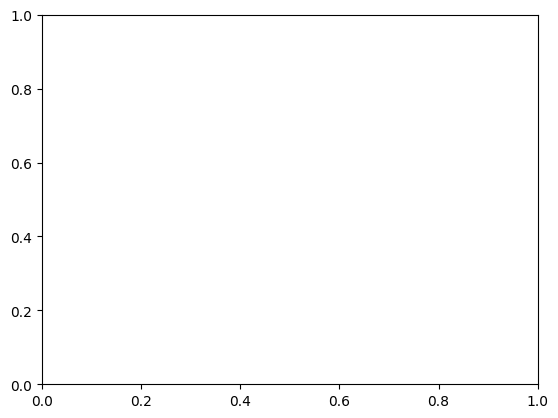

In [70]:
#example dataset 
adata = sc.read_h5ad("test_data/test_data1.h5ad")
# X, y = load_digits(return_X_y=True)
res = tsne(adata.X.toarray(), T=1000, l=200, perp=40)
plt.scatter(res[:, 0], res[:, 1], s=20, c=y)
plt.show()